In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
# from qiskit import *
import numpy as np
# from qiskit_algorithms import VQC
# from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
# from qiskit.aqua import QuantumInstance
# from qiskit.aqua.algorithms import VQC
import time
import numpy
import pandas as pd

In [45]:
import qiskit

*This is a guide following https://www.qmunity.tech/tutorials/building-a-variational-quantum-classifier and adjusted for newer version of qiskit*

# Step One : Download the dataset and load the data

In [2]:
image_size = 28 # width and length are equal
data_path = "./dataset/"

In [17]:
train_data = pd.read_csv(data_path + "mnist_train.csv", delimiter=',').to_numpy()
test_data = pd.read_csv(data_path + "mnist_test.csv", delimiter=',').to_numpy()

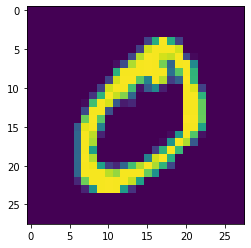

In [18]:
image = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(image)
plt.show()

# Step Two : Apply Dimensionality Reduction Technique

In [19]:
train_data_features = train_data[:10000,1:]
train_data_labels = train_data[:10000,:1].reshape(10000,)

In [20]:
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

In [22]:
X_SVD.shape

(10000, 10)

In [23]:
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [24]:
# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


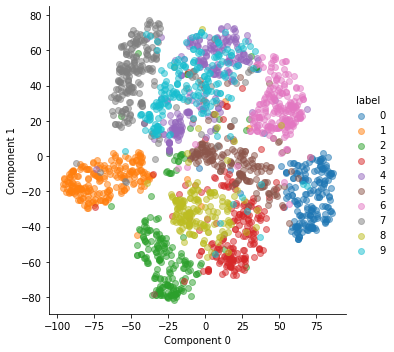

In [25]:
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

# Step Three : Extracting and Normalizing Data

We will extract data points corresponding to the digits 0 and 1 from the reduced dataset and normalize their features to be between 0 and 2.

In [26]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])

zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)


In [33]:
np.max(np.abs(zero_datapoints_array))

88.55359

In [34]:
np.max(np.abs(one_datapoints_array))

98.023506

In [58]:

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

# Step Four : The Variational Quantum Classifier

The main steps of this algorithm are:

1. Load Data onto the Quantum Computer by Applying a Quantum Feature Map Φ(x)‍

2. Build and apply short-depth Variational Circuit W(θ).

# Step Five : Implementing the Quantum Feature Map

In [37]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
pauli_feature_map.decompose().draw()

┌───┐┌─────────────┐┌───┐┌─────────────┐┌───┐┌─────────┐     »
q_0: ┤ H ├┤ P(2.0*x[0]) ├┤ H ├┤ P(2.0*x[0]) ├┤ H ├┤ Rx(π/2) ├──■──»
     ├───┤├─────────────┤├───┤├─────────────┤├───┤└─────────┘┌─┴─┐»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ H ├┤ P(2.0*x[1]) ├┤ H ├───────────┤ X ├»
     └───┘└─────────────┘└───┘└─────────────┘└───┘           └───┘»
«                                          ┌──────────┐
«q_0: ──────────────────────────────────■──┤ Rx(-π/2) ├
«     ┌──────────────────────────────┐┌─┴─┐└──────────┘
«q_1: ┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├────────────
«     └──────────────────────────────┘└───┘

Appending a Variational Circuit \
In this step we will append a variational circuit to the feature map. The parameters of this variational circuit are  trained using classical optimizers until it classifies the data points correctly. This is the training stage of the algorithm and accuracy of the model depends on the variational circuit one chooses.

In [52]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit.circuit import QuantumCircuit, ParameterVector

In [48]:

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)

In [49]:
variational_circ.draw()

┌──────────────────────────────────────────────────────────┐
q_0: ┤0                                                         ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                         ├
     └──────────────────────────────────────────────────────────┘

In [51]:
var_circuit = EfficientSU2(feature_dim, reps=2)

The following steps need to be done in order to create a custom feature map:

1. Create a ParameterVector object which stores the list of Parameters
2. Create QuantumCircuit object
3. Iterative over the number of qubits and add the gates.

In [56]:
num_qubits = 3            
iter = 1              # number of times you'd want to repeat the circuit

x = ParameterVector('x', length=num_qubits)  # creating a list of Parameters
custom_circ = QuantumCircuit(num_qubits)

# defining our parametric form
for _ in range(iter):
    for i in range(num_qubits):
        custom_circ.rx(x[i], i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u(0,0,x[i] * x[j], j) # equivalent to u1( lambda)
            custom_circ.cx(i, j)
            
custom_circ.draw()

┌──────────┐                                                            »
q_0: ┤ Rx(x[0]) ├──■────────────────────────■────■────────────────────────■──»
     ├──────────┤┌─┴─┐┌──────────────────┐┌─┴─┐  │                        │  »
q_1: ┤ Rx(x[1]) ├┤ X ├┤ U(0,0,x[0]*x[1]) ├┤ X ├──┼────────────────────────┼──»
     ├──────────┤└───┘└──────────────────┘└───┘┌─┴─┐┌──────────────────┐┌─┴─┐»
q_2: ┤ Rx(x[2]) ├──────────────────────────────┤ X ├┤ U(0,0,x[0]*x[2]) ├┤ X ├»
     └──────────┘                              └───┘└──────────────────┘└───┘»
«                                   
«q_0: ──────────────────────────────
«                                   
«q_1: ──■────────────────────────■──
«     ┌─┴─┐┌──────────────────┐┌─┴─┐
«q_2: ┤ X ├┤ U(0,0,x[1]*x[2]) ├┤ X ├
«     └───┘└──────────────────┘└───┘

# Step Six : Performing the Classification Task

We will take a very small subset of 20 training datapoints and 10 testing datapoints. We also keep 5 points per label as a validation set. We will first define the training and testing inputs based on the dataset we initialized before.

In [82]:
from sklearn.model_selection import train_test_split

In [85]:
dataset_size = 30

In [87]:
zero_datapoints_normalized

array([[1.7145554 , 0.69372725],
       [1.7558032 , 0.6596831 ],
       [1.5845476 , 0.5969665 ],
       ...,
       [1.7113832 , 0.56723815],
       [1.8043995 , 0.97944975],
       [1.8122126 , 0.9776646 ]], dtype=float32)

In [88]:
X = np.concatenate([zero_datapoints_normalized[np.random.choice(zero_datapoints_normalized.shape[0],dataset_size,replace=False),:], one_datapoints_normalized[np.random.choice(one_datapoints_normalized.shape[0],dataset_size,replace=False),:]])
y = np.concatenate([[0]*dataset_size,[1]*dataset_size])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Instantiate the Feature Map

In [90]:
seed = 10598
feature_dim = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
feature_map.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘

Instantiate the Classical Optimizer

In [91]:
from qiskit_algorithms.optimizers import COBYLA
cobyla = COBYLA(maxiter=500, tol=0.001)

Instantiate the Variational Circuit

In [92]:
var_circuit = EfficientSU2(feature_dim, reps=2)
var_circuit.decompose().draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ Rz(θ[10]) ├
«     ├───────────┤
«q_1: ┤ Rz(θ[11]) ├
«     └───────────┘

Executing the circuit and running it

In [2]:
from qiskit_machine_learning.algorithms.classifiers import  VQC


In [3]:
VQC?

Init signature:
VQC(
    num_qubits: 'int | None' = None,
    feature_map: 'QuantumCircuit | None' = None,
    ansatz: 'QuantumCircuit | None' = None,
    loss: 'str | Loss' = 'cross_entropy',
    optimizer: 'Optimizer | Minimizer | None' = None,
    warm_start: 'bool' = False,
    quantum_instance: 'QuantumInstance | Backend | None' = None,
    initial_point: 'np.ndarray | None' = None,
    callback: 'Callable[[np.ndarray, float], None] | None' = None,
    *,
    sampler: 'BaseSampler | None' = None,
) -> 'None'
Docstring:     
A convenient Variational Quantum Classifier implementation.

The variational quantum classifier (VQC) is a variational algorithm where the measured
bitstrings are interpreted as the output of a classifier.

Constructs a quantum circuit and corresponding neural network, then uses it to instantiate a
neural network classifier.

Labels can be passed in various formats, they can be plain labels, a one dimensional numpy
array that contains integer labels like `[0, 1

In [94]:
from qiskit.providers import basicaer


In [95]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [96]:
vqc = VQC( 
    feature_map=feature_map, 
    ansatz=var_circuit,
    optimizer=cobyla,
    callback=callback_graph,
    )

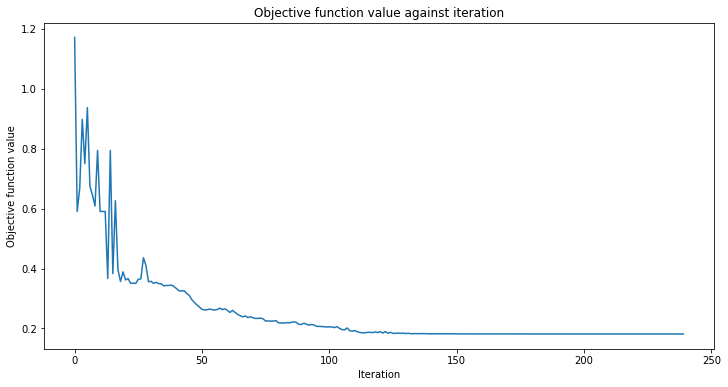

In [97]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start



In [98]:
print(f"Training time: {round(elapsed)} seconds")

Training time: 118 seconds


In [100]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 1.00
Quantum VQC on the test dataset:     1.00
